# Tarea #4: MA5203 Aprendizaje de Máquinas Probabilístico

##  Redes Neuronales y MNIST (75%)

En esta tarea deberán implementar una __red neuronal convolucional__ (CNN) profunda para resolver el problema de clasificación de las imágenes de dígitos escritos a mano (MNIST), en donde se espera que alcancen mayores niveles de accuracy que con la red neuronal feedforward mostrada en el tutorial de TensorFlow.

Para esto:
> + Diseñarán la arquitectura de una red convolucional <br>
> + Ajustarán un algoritmo de optimización de su preferencia <br>
> + Regularizarán la red neuronal <br>

### 1) Instrucciones

Debe entregar el Jupyter Notebook completando en el código las secciones indicadas y señalizadas específicamente por (...). Puede agregar o quitar partes del diseño de la arquitectura como estime conveniente. También deberá entregar un informe de __máximo 2 planas__ que incluya:

> + Arquitectura de la red <br>
> + Ajuste de hiperparámetros y optimizador elegido<br>
> + Regularización y entrenamiento <br>
> + Presentación de resultados <br>
> + Análisis de resultados y conclusiones <br>



In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile

from google.colab import files

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.tools import inspect_checkpoint as chkp

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import confusion_matrix

import pdb
import itertools

FLAGS = None

### 2) Fase de construcción

La primera función a construir es _deepnn()_, que construye el grafo con la arquitectura de la red convolucional con la que se resolverá el problema. Esta debe contener la siguiente estructura (como mínimo) dentro de los _name scopes_:
+ 'reshape': haz un reshape al input para usarlo dentro de una red convolucional (https://www.tensorflow.org/api_docs/python/tf/reshape) <br>
+ capa de convolución (se recomienda más de 1):
> + 'conv': capa de convolución <br>
> + 'pool': capa de pooling <br>
> + 'fc': capa fully connected <br>
+ 'droput': máscara de dropout para regularización (puede usar otra técnica) (https://www.tensorflow.org/api_docs/python/tf/nn/dropout) <br>
+ 'cl_layer': capa de clasificación <br>

In [0]:
def deepnn(x):
    """
  Función que construye el grafo de una red profunda
  
  --------PUEDE AGREGAR O QUITAR ELEMENTOS DE LA CAPA PREDEFINIDA MÁS ADELANTE------
  
  Args:
    x: tensor de input con dimensiones (N_examples, 784)
  Returns:
    Una tupla (y, keep_prob), con y un tensor de dimensión (N_examples, 10),
    con los valores de los logits de clasificar el dígito en una de las 10 classes,
    y keep_prob un escalar placeholder para la probabilidad de dropout.
  """
  
  ####----------------- (1) COMPLETAR ---------------------#####
    
    # Reshape para usar input en una red convolucional (hint: se debe hacer un 'flatten' a 1D)
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])
        
  ####---------------- fin completar -----------------#####

  ####----------------- (2) COMPLETAR ---------------------#####
    
    with tf.name_scope('conv1'):
        shape = [3, 3, 1, 32]
        W_conv1 = weight_variable(shape)
        b_conv1 = bias_variable([32])
        # Ver el bloque de más abajo para las funciones conv2d, max_pool_2x2,
        # weight_variable, y bias_variable
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    with tf.name_scope('conv2'):
        shape = [3, 3, 32, 64]
        W_conv2 = weight_variable(shape)
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)

    with tf.name_scope('fc1'):
        layer_shape_in =  h_pool2.get_shape()
        num_features_in = layer_shape_in[1:4].num_elements()
        W_fc1 = weight_variable([num_features_in, 1024])
        b_fc1 = bias_variable([1024])

        # El argumento -1 hace 'flatten' a 1D
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
  ####---------------- fin completar -----------------#####

 ####----------------- (3) COMPLETAR ---------------------#####
    
    # Implementar regularización por dropout
    with tf.name_scope('dropout'):
        h_fc1_drop = tf.nn.dropout(h_fc1, 0.9)
        
  ####---------------- fin completar -----------------#####

 ####----------------- (4) COMPLETAR ---------------------#####
    
  # Map un número de features al número de clases
    with tf.name_scope('cl_layer'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        
    return y_conv
        
  ####---------------- fin completar -----------------#####

A continuación se definen funciones que le serán útiles para la arquitectura definida en deep_nn():

In [0]:
def conv2d(x, W):
    """conv2d retorna una capa de convolución 2D con full stride"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 hace downsample al feature map por 2X"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

 ####----------------- (5) COMPLETAR ---------------------##### 

def weight_variable(shape):
    """weight_variable genera una variable de peso dadas ciertas dimensiones"""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable genera una variable de bias dado cierto shape"""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
        
  ####---------------- fin completar -----------------#####

### 3) Fase de ejecución

En esta etapa, antes de ejecutar la sesión deberá definir los name scopes de:
+ 'loss': función de costos a optimizar <br>
+ 'my_optimizer': algoritmo de optimización e hiperparámetros que utilizará en el entrenamiento <br>
Algunas opciones (se valorizará el uso de un algoritmo distinto al mostrado en el tutorial):
> + __Descenso por el gradiente__, __descenso estocástico por el gradiente__, __descenso por el gradiente con mini-batches__: https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer <br>
> + __RMSProp__ (algoritmo con momentum): https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer <br>
> + __Adagrad__ (algoritmo con learning rates adaptativos): https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer <br>
> + __Adam__ (algoritmo con momentum y learning rates adaptativos): https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer <br>
+ 'accuracy': métrica de desempeño

__Tenga en consideración que la siguiente etapa puede tomar una cantidad significativa de tiempo (3 min ~ 1,000 epochs)__

In [4]:
# Función que realiza la fase de ejecución
def main(mnist_data):
    # Importar datos
    mnist = input_data.read_data_sets(mnist_data)
    
 ####----------------- (6) COMPLETAR ---------------------#####

    # Inputs, etiquetas, y output de la red convolucional
    x = tf.placeholder(tf.float32, shape=(None, 28*28))
    y_ = tf.placeholder(tf.int64, shape=(None))
    y_conv = deepnn(x)
        
  ####---------------- fin completar -----------------#####

 ####----------------- (7) COMPLETAR ---------------------#####
    
    # Función objetivo, optimizador y evaluación
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                              logits=y_conv)
        cross_entropy = tf.reduce_mean(cross_entropy)

    with tf.name_scope('my_optimizer'):
        learning_rate=0.1
        train_step = tf.train.GradientDescentOptimizer(learning_rate)
        train_step = train_step.minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        
  ####---------------- fin completar -----------------#####

    graph_location = tempfile.mkdtemp()
    print('Saving graph to: %s' % graph_location)
    train_writer = tf.summary.FileWriter(graph_location)
    train_writer.add_graph(tf.get_default_graph())

 ####----------------- (8) COMPLETAR ---------------------#####
    
    batch_size = 100
    n_epochs = 5
    batches_per_epoch = int(mnist.train.num_examples / batch_size)
#     pdb.set_trace()
    probabilidad = tf.constant(1, dtype=tf.float32)
  
    loss_array = []
    train_acc = []
    val_acc = []
    test_acc = []   
    cnf_matrix = []
    
    # Ejecutar la sesión que entrena la red convolucional
    with tf.Session() as sess:
        #Inicialice las variables
        init = tf.global_variables_initializer()
        init.run()        
        for i in range(n_epochs * batches_per_epoch):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            # Imprimir métricas cada 100 batches
            if i % 100 == 0:
                train_accuracy = accuracy.eval(feed_dict={x: X_batch, y_: y_batch})
                print('step %d, training set accuracy %g' % (i, train_accuracy))
                validation_accuracy = accuracy.eval(feed_dict={x: mnist.validation.images,
                                            y_: mnist.validation.labels})
                print('validation set accuracy %g' % validation_accuracy)
                test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images,
                                            y_: mnist.test.labels})
                print('test set accuracy %g' % test_accuracy)
                #pdb.set_trace()
                loss_array.append(cross_entropy.eval(feed_dict={x: X_batch, y_: y_batch}))
                train_acc.append(train_accuracy)
                val_acc.append(validation_accuracy)
                test_acc.append(test_accuracy)
            # El argumento keep_prob indica la probabilidad de mantener un nodo de input
            # (es dropout aplicado al input)            
            sess.run(train_step, feed_dict={x: X_batch, y_: y_batch})
    
    
        X_new_scaled = mnist.test.images
        Z = y_conv.eval(feed_dict={x: X_new_scaled})
        y_pred = np.argmax(Z, axis=1)
        cnf_matrix.append(confusion_matrix(mnist.test.labels, y_pred))
    
    return loss_array, train_acc, val_acc, test_acc, cnf_matrix[0]
  ####---------------- fin completar -----------------#####

# Esta parte del código ejecuta la función main(). No necesitas modificarla
#if __name__ == '__main__':
#    parser = argparse.ArgumentParser()
#    parser.add_argument('--data_dir', type=str,
#                      default='/tmp/tensorflow/mnist/input_data',
#                      help='Directory for storing input data')
#    FLAGS, unparsed = parser.parse_known_args()
#    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)
loss_array, train_acc, val_acc, test_acc, cnf_matrix = main("/tmp/tensorflow/mnist/input_data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as o

### 4) Resultados

Muestre curvas de aprendizaje (e.g., pérdida en función de épocas), comparación entre los distintos sets, matrices de confusión y análisis de error en el resultado

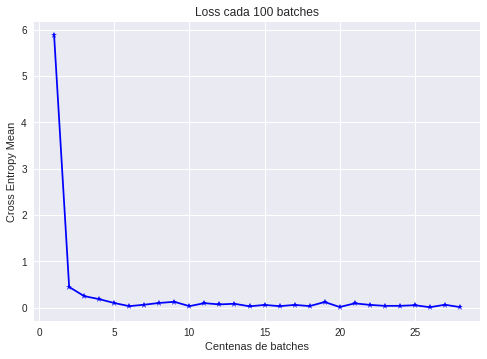

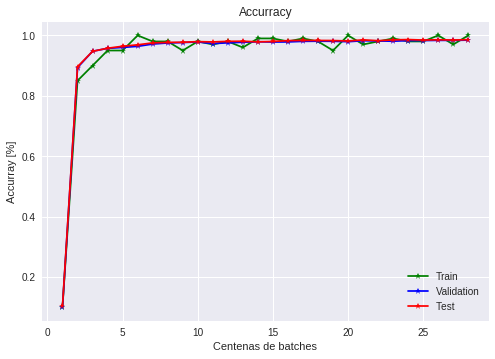

In [5]:
x_axis = np.linspace(1, len(loss_array), num=len(loss_array))

plt.figure()
plt.plot(x_axis, loss_array, 'b-*')
plt.title("Loss cada 100 batches")
plt.xlabel("Centenas de batches")
plt.ylabel("Cross Entropy Mean")
plt.savefig('loss.pdf')

plt.figure()
plt.plot(x_axis,train_acc, 'g-*')
plt.plot(x_axis,val_acc, 'b-*')
plt.plot(x_axis,test_acc, 'r-*')
plt.legend(["Train", "Validation", "Test"])

plt.title("Accurracy")
plt.xlabel("Centenas de batches")
plt.ylabel("Accurray [%]")
plt.savefig('accurracy.pdf')

files.download('loss.pdf')
files.download('accurracy.pdf')
  

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = 100 * cm / cm.sum(1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

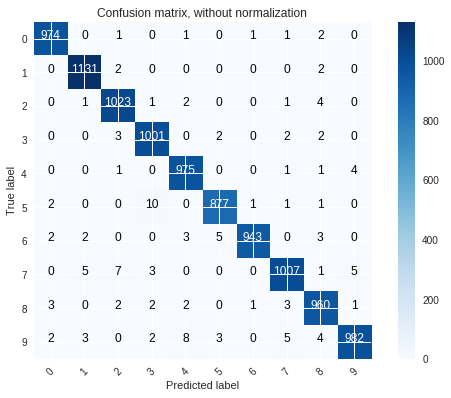

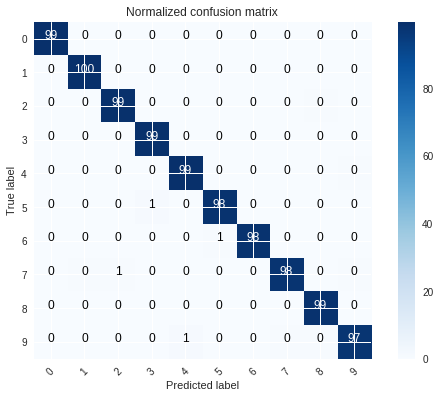

In [7]:
#Calcular la matriz de confusión
np.set_printoptions(precision=2)
class_names = range(10)

#Plotear la matriz de confusión no-normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('confusion.pdf')

#Plotear la matriz de confusión normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion_norm.pdf')

plt.show()

files.download('confusion.pdf')
files.download('confusion_norm.pdf')

## Proyecto (25%)

Defina sucintamente el objetivo de su proyecto, enmárquelo en alguna de las temáticas del curso (regresión, clasificación, clustering, reducción de dimensionalidad, etc.) e identifique sus datos con la notación vista en clase (e.g., defina sus _inputs_ y _labels_ si su problema es de clasificación). Además, explore las herramientas clásicas para resolver su problema e implemente al menos una con sus datos. 

Extensión máxima para esta parte: **2 páginas**.